# Stock Trading using Reinforcement Learning

In this notebook, we develop a machine learning model to decide on buying, selling, or holding stock. We also train the model to consider various environmental factors. We use reincofrcement learning in this model, which is a branch of ML where a model takes suitable action to maximize reward in a particular situation. We use Q-learning to train the model, with the goal to develop a policy for the model to act under different circumstances. 

In [1]:
#!pip install torch==1.2.0+cpu torchvision==0.4.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
#!pip install plotly
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
import os
import tensorflow as tf
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

c:\python37\lib\site-packages\tensorflow\python\fram

In [2]:
msft_data = pd.read_csv('MSFT.csv')
msft_data['Date'] = pd.to_datetime(msft_data['Date'])
msft_data = msft_data.set_index('Date')
msft_data = msft_data.drop(columns=["Close"])
msft_data.head()
#print(msft_data.index.min(), msft_data.index.max())

googl_data = pd.read_csv("GOOGL.csv")
googl_data['Date'] = pd.to_datetime(googl_data['Date'])
googl_data = googl_data.set_index('Date')
googl_data = googl_data.drop(columns=["Close"])
googl_data.head()

amzn_data = pd.read_csv("AMZN.csv")
amzn_data['Date'] = pd.to_datetime(amzn_data['Date'])
amzn_data = amzn_data.set_index('Date')
amzn_data = amzn_data.drop(columns=["Close"])
amzn_data.head()

ibm_data = pd.read_csv("IBM.csv")
ibm_data['Date'] = pd.to_datetime(ibm_data['Date'])
ibm_data = ibm_data.set_index('Date')
ibm_data = ibm_data.drop(columns=["Close"])
ibm_data.head()

aapl_data = pd.read_csv("AAPL.csv")
aapl_data['Date'] = pd.to_datetime(aapl_data['Date'])
aapl_data = aapl_data.set_index('Date')
aapl_data = aapl_data.drop(columns=["Close"])
aapl_data.head()

Open   High    Low  Adj Close     Volume
Date                                                 
2010-01-04  30.49  30.64  30.34      26.78  123432400
2010-01-05  30.66  30.80  30.46      26.83  150476200
2010-01-06  30.63  30.75  30.11      26.40  138040000
2010-01-07  30.25  30.29  29.86      26.35  119282800
2010-01-08  30.04  30.29  29.87      26.53  111902700

In [3]:
date_split = '2018-01-01'
msft_train, msft_test = msft_data[:date_split], msft_data[date_split:]
googl_train, googl_test = googl_data[:date_split], googl_data[date_split:]
amzn_train, amzn_test = amzn_data[:date_split], amzn_data[date_split:]
ibm_train, ibm_test = ibm_data[:date_split], ibm_data[date_split:]
aapl_train, aapl_test = aapl_data[:date_split], aapl_data[date_split:]

#len(train),len(test)

In [4]:
def plot_train_test(train, test, date_split):
    
    data = [
        Candlestick(x=train.index, open=train['Open'], high=train['High'], low=train['Low'], close=train['Adj Close'], name='train'),
        Candlestick(x=test.index, open=test['Open'], high=test['High'], low=test['Low'], close=test['Adj Close'], name='test')
    ]
    layout = {
         'shapes': [
             {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data, layout=layout)
    iplot(figure)

In [5]:
print("Microsoft (MSFT)")
plot_train_test(msft_train, msft_test, date_split)

print("Google (GOOGL)")
plot_train_test(googl_train, googl_test, date_split)

print("Amazon (AMZN)")
plot_train_test(amzn_train, amzn_test, date_split)

print("IBM (IBM)")
plot_train_test(ibm_train, ibm_test, date_split)

print("Apple (AAPL)")
plot_train_test(aapl_train, aapl_test, date_split)


Microsoft (MSFT)


Google (GOOGL)


Amazon (AMZN)


IBM (IBM)


Apple (AAPL)


### Initialization

In the Environment class we initialize the trading environment to train and test the model. We mantain a position list of the current stocks, the position value of the agent, and the contribution of the change in stock prices to the agent.  The position list includes the list of current stocks with the trading bot. The position value of the trade bot and the delta of the stock prices changes contribute to the observation set for the Tradebot.

We also define a step function for the agent to act upon at each step. At any given step, the agent has three options to choose between; to buy, sell, or hold. If the agent decides to buy, its position increases. If the agent decides to sell, its profit will be the difference of the sold price and the buying price. To make sure the model does not sell while not having any positions, it is penalised with a reward of -1.

Next, the agent updates its history with the change or delta of stock prices. If the current step yields a profit, the agent is rewarded +1 and if the current step leads to a loss, the agent is penalised with -1. We also mantain a list of the bot's position at each step.


In [6]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # print(act)
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1: # buy
            self.positions.append(self.data.iloc[self.t, :]['Adj Close'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Adj Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Adj Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Adj Close'] - self.data.iloc[(self.t-1), :]['Adj Close'])
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done, self.data.iloc[self.t, :]['Adj Close'] # obs, reward, done
    

### Initialization of the model

In [7]:
#def train_dqn(env):
    
class Q_Network(nn.Module):
        
    def __init__(self,obs_len,hidden_size,actions_n):
            
        super(Q_Network,self).__init__()
            
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
        
        
    def forward(self,x):
        h =  self.fc_val(x)
        return (h)
            

### Initializing environment for Model

In [8]:
epoch_num = 50 #50

memory_size = 30 #200
batch_size = 30 #50

def initialize_env(train):
    env = Environment1(train)

    hidden_size=100
    input_size=env.history_t+1
    output_size=3
    USE_CUDA = False
    LR = 0.001

    Q = Q_Network(input_size, hidden_size, output_size)

    Q_ast = copy.deepcopy(Q)

    if USE_CUDA:
        Q = Q.cuda()
    optimizer = optim.Adam(list(Q.parameters()), lr=LR)

    step_max = len(env.data)-1
 
    obs, reward, done, _ = env.step(5)
    
    return env, Q, Q_ast, train, step_max, optimizer

### Decision Making for our Model

The performed action is passed through the environment and is used to generate a the new set rewards and observations for carrying the step. The observations contains the current position value for the agent, and the profit or loss we currently have from the agent.

In [9]:
def perform_action(Q, epsilon, memory, memory_size, env, pobs):
    # select act
    pact = np.random.randint(3)
    if np.random.rand() > epsilon:
        pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
        pact = np.argmax(pact.data)
        pact = pact.numpy()

    # act
    obs, reward, done, price = env.step(pact)

    # add memory
    memory.append((pobs, pact, reward, obs, done))
    if len(memory) > memory_size:
        memory.pop(0)
        
    return Q, pact, obs, reward, done, price

### Updating our Q table

Our Q table is updated by ther following; We update the Q values for each set of action and its corresponding state (action prediciton, performing an action,measuring reward ). The optimizer is used to update the Q values for minimizing the loss to yield the best result.

In [10]:
def update_q(Q, Q_ast, pobs, obs, memory, update_q_freq, step, total_step, train_freq, gamma, loss_function, 
             epsilon, epsilon_min, epsilon_decrease, start_reduce_epsilon, reward, total_reward, total_loss, optimizer):
    if total_step % train_freq == 0:
                    
        shuffled_memory = np.random.permutation(memory)
        memory_idx = range(len(shuffled_memory))
        for i in memory_idx[::batch_size]:
            batch = np.array(shuffled_memory[i:i+batch_size])
            b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
            b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
            b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
            b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
            b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

            q = Q(torch.from_numpy(b_pobs))
            q_ = Q_ast(torch.from_numpy(b_obs))
            maxq = np.max(q_.data.numpy(),axis=1)
            target = copy.deepcopy(q.data)
            for j in range(batch_size):
                target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
            Q.zero_grad()
            loss = loss_function(q, target)
            total_loss += loss.data.item()
            loss.backward()
            optimizer.step()

    if total_step % update_q_freq == 0:
        Q_ast = copy.deepcopy(Q)

    # epsilon
    if epsilon > epsilon_min and total_step > start_reduce_epsilon:
        epsilon -= epsilon_decrease

    # next step
    total_reward += reward
    pobs = obs
    step += 1
    total_step += 1
    return total_reward, total_loss, pobs, step, total_step, Q, Q_ast, epsilon

### Training the Model

Using argmax, the model predicts the highest-yielding probable action for the initial set of observations using argmax. This predicted action is then passed through the environment and is then used to generate the new set of observations. The reward for carrying the step indicating whether the episode is over is handled by the done boolean. The memory is list which asks as a buffer to keep track of the previous actions and the corresponding observations, rewards and new set of observations.

In [11]:
def rl_train(env, Q, Q_ast, train, step_max, optimizer, start = time.time(), memory = [], total_step = 0,  total_rewards = [],
    total_losses = [], epsilon = 1.0, epsilon_decrease = 1e-3, epsilon_min = 0.1, start_reduce_epsilon = 200, train_freq = 10,
    update_q_freq = 20, gamma = 0.97, show_log_freq = 5, loss_function = nn.MSELoss()):

    for epoch in range(epoch_num):
        
        # Initialize environment after every epoch
        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
   
        while not done and step < step_max:
            
            # Perform action (Buy, Sell, or Hold)
            Q, pact, obs, reward, done, price = perform_action(Q, epsilon, memory, memory_size, env, pobs)

            # train or update q
            if len(memory) == memory_size:
                total_reward, total_loss, pobs, step, total_step, Q, Q_ast, epsilon = update_q(Q, Q_ast, pobs, obs, memory, update_q_freq, step, total_step, train_freq, gamma, loss_function, 
                                                                                      epsilon, epsilon_min, epsilon_decrease, start_reduce_epsilon, reward, total_reward, total_loss, 
                                                                                      optimizer)

            total_rewards.append(total_reward)
            total_losses.append(total_loss)

            if (epoch+1) % show_log_freq == 0:
                log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
                log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
                elapsed_time = time.time()-start
                #print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
                start = time.time()
        print("Epoch:", epoch+1, " Reward:", total_reward, " Loss:", total_loss)
    print("")
    
    return Q, total_losses, total_rewards
    

### Calculating and Getting the profits

We track our actions, prices and rewards at each step in our test. We also generate a graph and scatterplot of these values to compare with the actual dest data set.

In [12]:
def calc_profits(Q, test, stock):
    test_env = Environment1(test)
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    prices = []
    actions = []
    for _ in range(len(test_env.data)-1):

        pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
        pact = np.argmax(pact.data)
        test_acts.append(pact.item())
        
        obs, reward, done, price = test_env.step(pact.numpy())
        test_rewards.append(reward)
        prices.append(price)
        actions.append(pact)

        pobs = obs
    
    sess = tf.InteractiveSession()
    actions = [act.item() for act in actions]
    # Other ops
    sess.close()
    
    colors = []
    for a in actions:
        if a == 1:
            colors.append("#00ff00")
        elif a == 2:
            colors.append("#ff0000")
        else:
            colors.append("#ffffff00")
         
    
    plt.figure()
    plt.plot(prices)
    plt.scatter(np.arange(0, len(actions)), prices,c=colors)
    plt.title("Actual Prices " + stock)
    plt.ylabel("Price")
    plt.xlabel("Days")
    plt.legend()
    plt.savefig(stock + '_RL_actions.png')
    plt.show()
    
    start = 0
    end = start+len(actions)//8
    for i in range(8):
        plt.figure()
        plt.plot(prices[start:end])
        plt.scatter(np.arange(0, len(actions[start:end])), prices[start:end],c=colors[start:end])
        plt.title("Actual Prices " + stock + " Days " +str(start) + "-" + str(end))
        plt.ylabel("Price")
        plt.xlabel("Days")
        plt.legend()
        plt.savefig(stock + '_RL_actions_' + str(start) + "-" + str(end) + '.png');
        start += len(actions)//8
        end += len(actions)//8

    test_profits = test_env.profits
    return test_profits

In [13]:
def run_rl(train):
    env, Q, Q_ast, train_new, step_max, optimizer = initialize_env(train)
    Q_, total_losses, total_rewards = rl_train(env, Q, Q_ast, train, step_max, optimizer)
    return Q_

In [14]:
def get_profits(retrain=False):
    data = [(msft_train, msft_test, "MSFT"), 
                     (googl_train, googl_test, "GOOGL"), 
                     (amzn_train, amzn_test, "AMZN"),
                     (ibm_train, ibm_test, "IBM"),
                     (aapl_train, aapl_test, "AAPL")] 
    profits = []
    for train, test, stock in data:
        if retrain:
            Q_ = run_rl(train)
            pickle.dump(Q_, open(stock +"_rl.h5", "wb"))
        else:
            Q_ = pickle.load(open(stock+"_rl.h5", "rb"))
        
        profits.append((calc_profits(Q_, test, stock), stock))
    return profits     

No handles with labels found to put in legend.


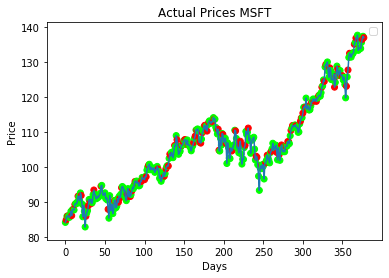

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


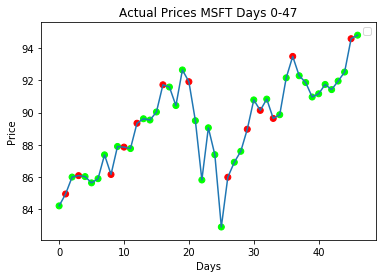

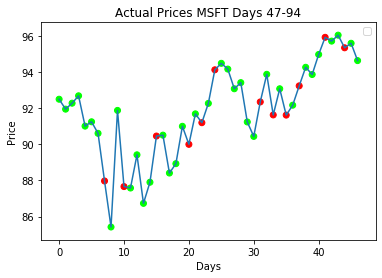

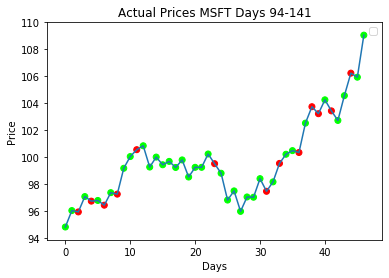

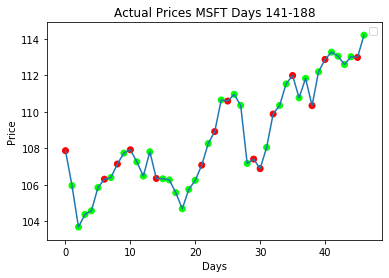

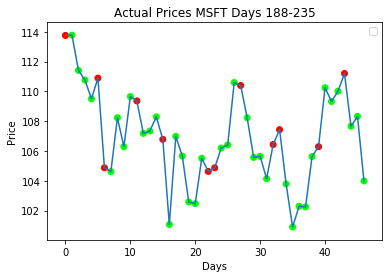

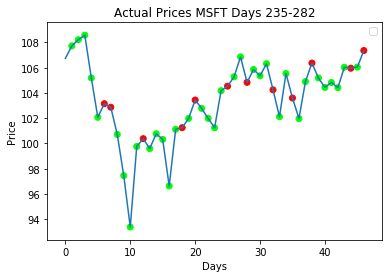

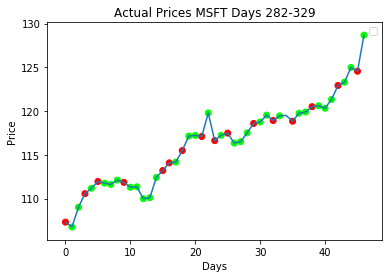

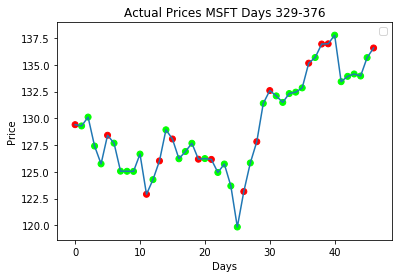

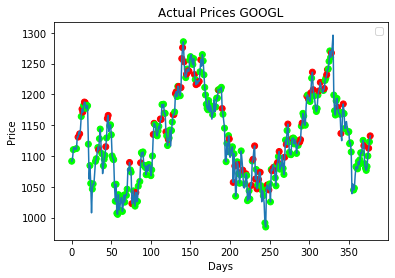

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


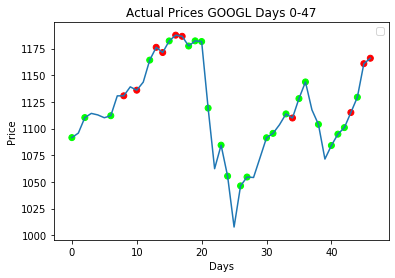

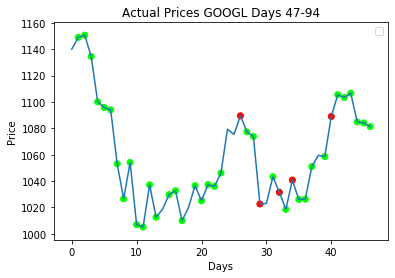

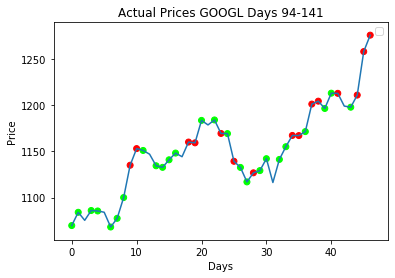

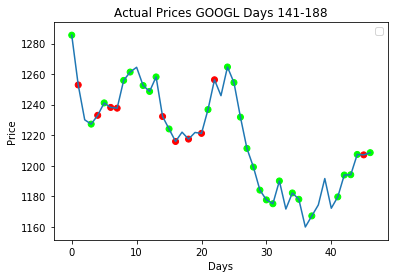

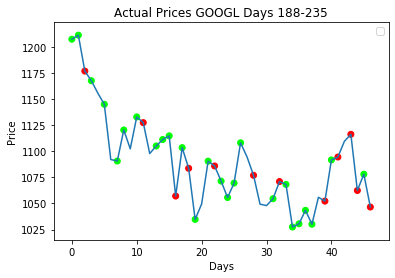

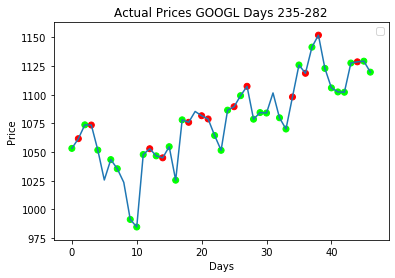

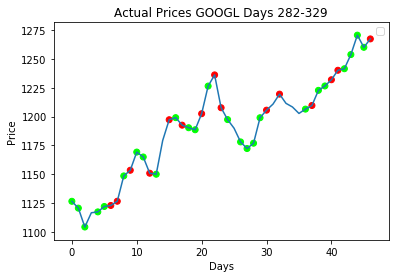

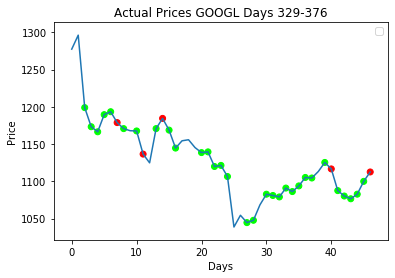

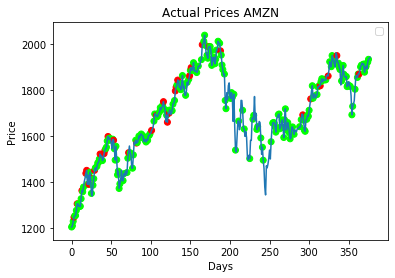

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


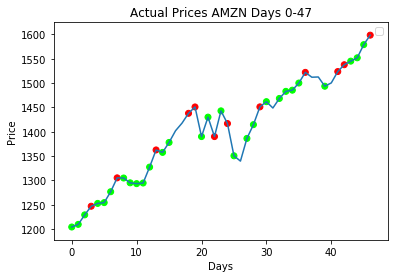

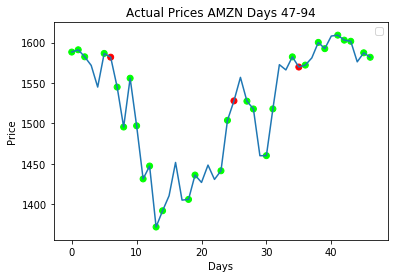

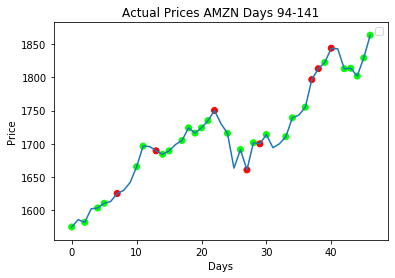

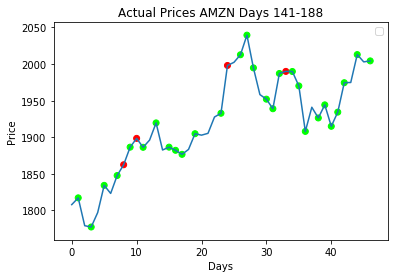

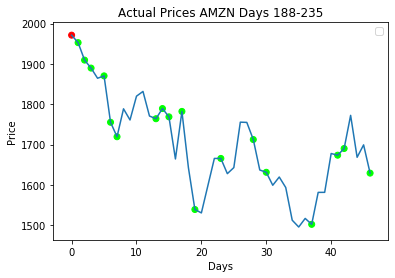

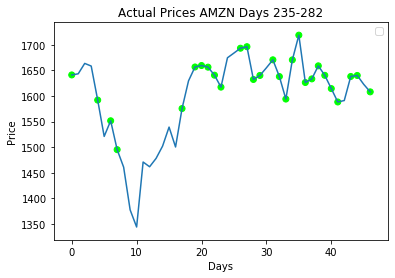

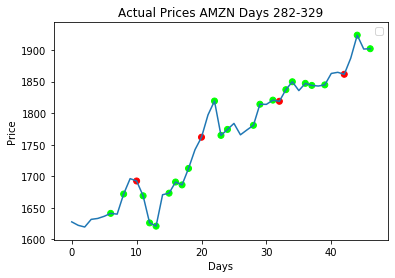

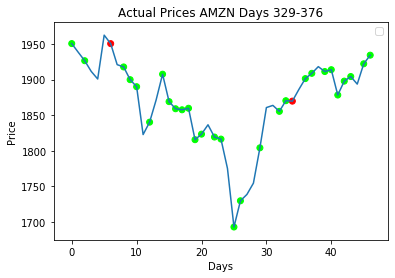

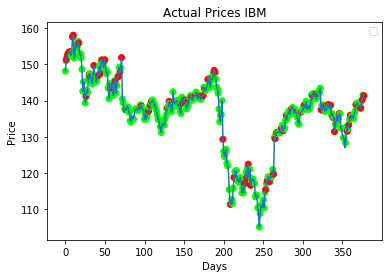

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


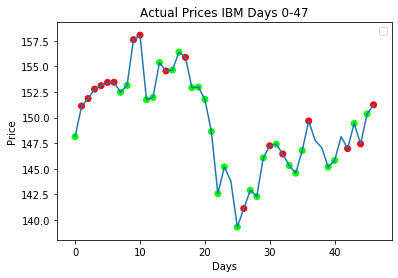

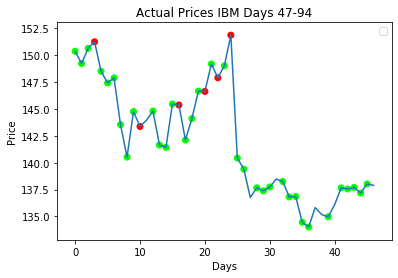

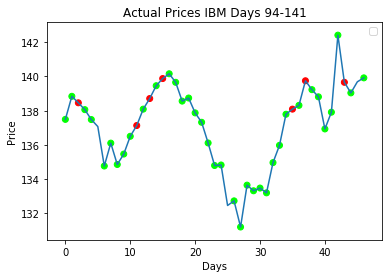

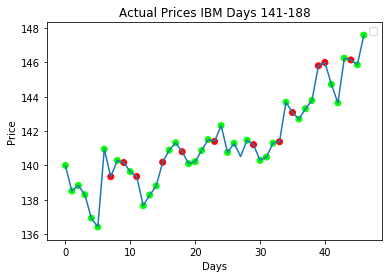

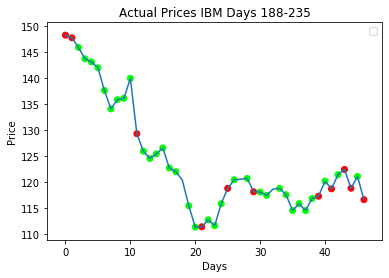

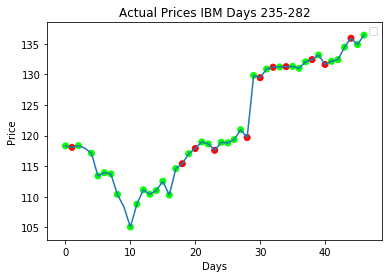

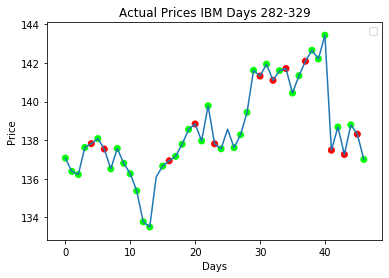

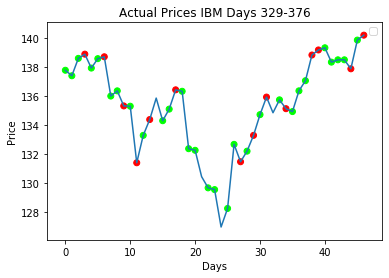

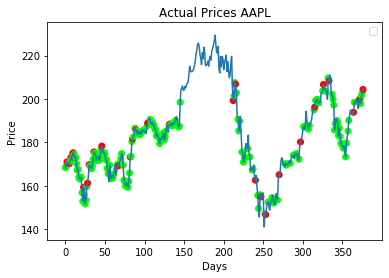

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


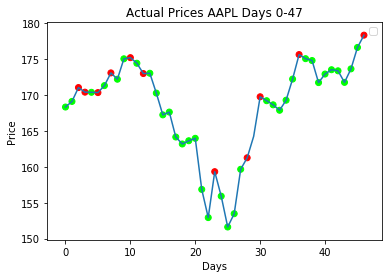

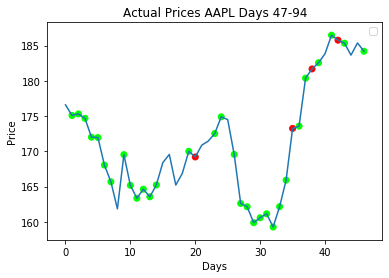

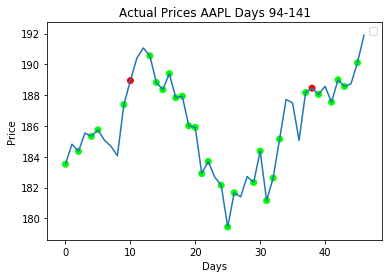

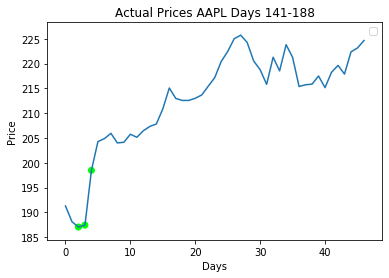

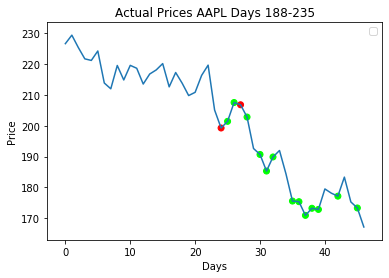

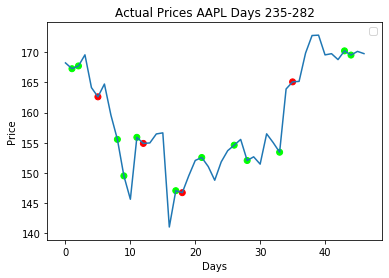

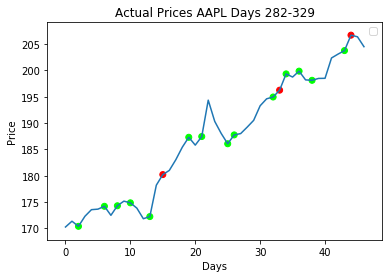

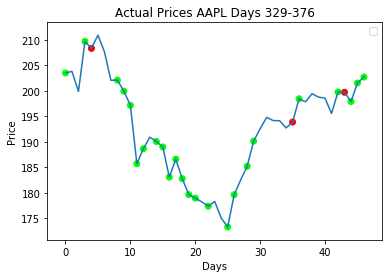

In [15]:
profits = get_profits(retrain=False)

In [16]:
profits

[(83.26000000000003, 'MSFT'),
 (2390.5099999999984, 'GOOGL'),
 (5752.950000000001, 'AMZN'),
 (137.88000000000005, 'IBM'),
 (264.60999999999945, 'AAPL')]